<a href="https://colab.research.google.com/github/DimitrisParaskevopoulos/Transfer-learning-feature-extraction/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Feature extraction transfer learning for great results with a small dataset**

*Transfer learning is leveraging what a state of the art Deep Learning model has already learned*

# Import data and make train/test set

In [2]:
# import files from local(desktop)

#from google.colab import files
#uploaded = files.upload()

Saving cat_vs_car.zip to cat_vs_car.zip


In [6]:
# import training/test set from GitHub repository
!wget https://raw.githubusercontent.com/DimitrisParaskevopoulos/Transfer-learning-feature-extraction/main/dataset/cat_vs_car.zip

--2021-10-17 17:27:00--  https://raw.githubusercontent.com/DimitrisParaskevopoulos/Transfer-learning-feature-extraction/main/dataset/cat_vs_car.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191469 (187K) [application/zip]
Saving to: ‘cat_vs_car.zip.2’

cat_vs_car.zip.2    100%[===================>] 186.98K  --.-KB/s    in 0.03s   

2021-10-17 17:27:00 (7.29 MB/s) - ‘cat_vs_car.zip.2’ saved [191469/191469]



In [4]:
import zipfile
zip_ref = zipfile.ZipFile("cat_vs_car.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [5]:
!ls cat_vs_car

test  train


In [6]:
!ls cat_vs_car/train/cat/

'images (1).jpg'  'images (6).jpg'  'ß±≈σ▀∩ δ▐°τ≥ (1).jpg'
'images (2).jpg'  'images (7).jpg'  'ÿ¿«£σª óπ»₧¬ (13).jpg'
'images (3).jpg'   images.jpg	    'ÿ¿«£σª óπ»₧¬.jpg'
'images (4).jpg'  'New folder'


In [7]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("cat_vs_car"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'cat_vs_car'.
There are 2 directories and 0 images in 'cat_vs_car/train'.
There are 1 directories and 10 images in 'cat_vs_car/train/cat'.
There are 0 directories and 0 images in 'cat_vs_car/train/cat/New folder'.
There are 0 directories and 10 images in 'cat_vs_car/train/car'.
There are 2 directories and 0 images in 'cat_vs_car/test'.
There are 0 directories and 4 images in 'cat_vs_car/test/cat'.
There are 0 directories and 4 images in 'cat_vs_car/test/car'.


In [8]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "cat_vs_car/train/"
test_dir = "cat_vs_car/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="binary",
                                               seed=42)

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="binary",
                                              seed=42)

Training images:
Found 20 images belonging to 2 classes.
Testing images:
Found 8 images belonging to 2 classes.


## Visualize data

 Visualize the images before making models

View a random image from the training dataset

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
    # Setup target directory (we'll view images from here)
    target_folder = target_dir+target_class

    # Get a random image path
    random_image = random.sample(os.listdir(target_folder), 1)

    # Read in the image and plot it using matplotlib
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off");

    print(f"Image shape: {img.shape}") # show the shape of the image

#    return img

Image shape: (134, 377, 3)


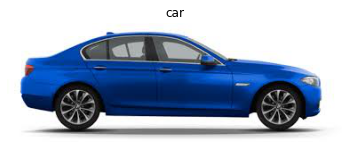

In [12]:
view_random_image('cat_vs_car/train/','car')

# Model building

## Create Callback

In [13]:
# Create tensorboard callback (functionized because need to create a new one for each model)
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Model of transfer learning and loss curves

In [14]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

I will try 3 different architectures(found them on tensorflowHub)

In [15]:
# Original: EfficientNetB0 feature vector (version 1)
efficientnet0_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# Original: EfficientNetB4 feature vector
efficientnet4_url = "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1"

# New: EfficientNetB0 feature vector (version 2)
efficientnetV2_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"


In [16]:
def create_model(model_url, num_classes):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE + (3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

In [17]:
# Create model
efficientnetB0_model = create_model(efficientnet0_url, num_classes=1)

# Compile
efficientnetB0_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

# Fit the model
efficientnetB0_history = efficientnetB0_model.fit(train_data,
                                  epochs=10,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="efficientnetB0")]) # name of log files

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20211017-123913
Epoch 1/10
1/1 [==============================] - 15s 15s/step - loss: 0.6928 - accuracy: 0.6500 - val_loss: 0.6699 - val_accuracy: 0.7500
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.6317 - accuracy: 0.7500 - val_loss: 0.6263 - val_accuracy: 0.7500
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.5748 - accuracy: 0.9000 - val_loss: 0.5852 - val_accuracy: 0.7500
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.5220 - accuracy: 0.9000 - val_loss: 0.5467 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.4733 - accuracy: 0.9000 - val_loss: 0.5107 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.4287 - accuracy: 0.9500 - val_loss: 0.4771 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.3879 - accuracy: 0.9500 - 

In [18]:
import matplotlib.pyplot as plt

# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

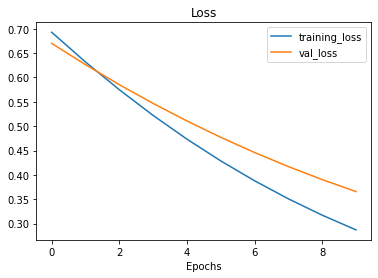

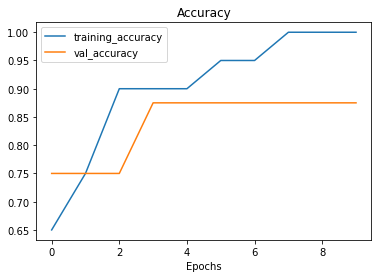

In [19]:
plot_loss_curves(efficientnetB0_history)

In [20]:
# Create model
efficientnetB4_model = create_model(model_url=efficientnet4_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=1)

# Compile EfficientNet model
efficientnetB4_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnetB4_history = efficientnetB4_model.fit(train_data,
                                              epochs=10,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB4")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetB4/20211017-124015
Epoch 1/10
1/1 [==============================] - 30s 30s/step - loss: 0.7532 - accuracy: 0.4500 - val_loss: 0.7580 - val_accuracy: 0.2500
Epoch 2/10
1/1 [==============================] - 6s 6s/step - loss: 0.6851 - accuracy: 0.5500 - val_loss: 0.7042 - val_accuracy: 0.7500
Epoch 3/10
1/1 [==============================] - 4s 4s/step - loss: 0.6221 - accuracy: 0.6500 - val_loss: 0.6544 - val_accuracy: 0.7500
Epoch 4/10
1/1 [==============================] - 4s 4s/step - loss: 0.5642 - accuracy: 0.8500 - val_loss: 0.6086 - val_accuracy: 0.8750
Epoch 5/10
1/1 [==============================] - 4s 4s/step - loss: 0.5113 - accuracy: 0.8500 - val_loss: 0.5663 - val_accuracy: 0.8750
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 0.4631 - accuracy: 0.9500 - val_loss: 0.5273 - val_accuracy: 0.8750
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 0.4193 - accuracy: 1.0000 - 

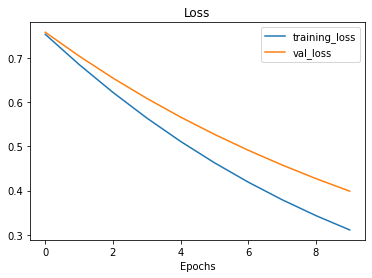

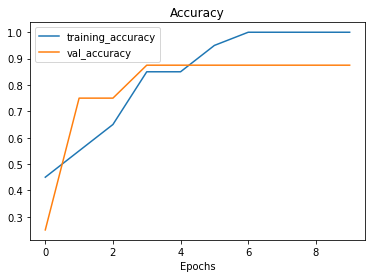

In [21]:
plot_loss_curves(efficientnetB4_history)

In [22]:
# Create model
efficientnetV2_model = create_model(model_url=efficientnetV2_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=1)

# Compile EfficientNet model
efficientnetV2_model.compile(loss='binary_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model 
efficientnetV2_history = efficientnetV2_model.fit(train_data,
                                              epochs=10,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub", 
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetV2")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetV2/20211017-124146
Epoch 1/10
1/1 [==============================] - 11s 11s/step - loss: 0.7881 - accuracy: 0.3000 - val_loss: 0.6337 - val_accuracy: 0.6250
Epoch 2/10
1/1 [==============================] - 2s 2s/step - loss: 0.7231 - accuracy: 0.4500 - val_loss: 0.5842 - val_accuracy: 0.7500
Epoch 3/10
1/1 [==============================] - 2s 2s/step - loss: 0.6620 - accuracy: 0.6500 - val_loss: 0.5378 - val_accuracy: 0.8750
Epoch 4/10
1/1 [==============================] - 2s 2s/step - loss: 0.6049 - accuracy: 0.6500 - val_loss: 0.4945 - val_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.5519 - accuracy: 0.7500 - val_loss: 0.4543 - val_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.5027 - accuracy: 0.8000 - val_loss: 0.4171 - val_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.4575 - accuracy: 1.0000 - 

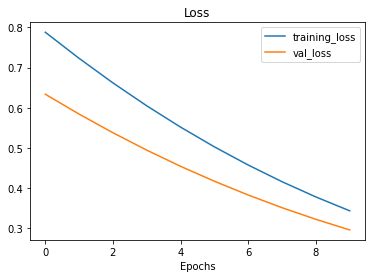

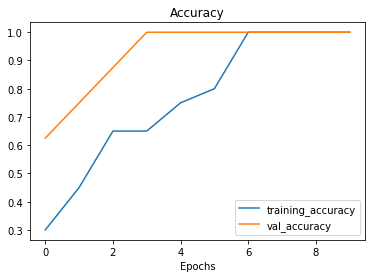

In [23]:
plot_loss_curves(efficientnetV2_history)

## Evaluate results to Tensorboard

If you want to see my results (https://tensorboard.dev/experiment/I3ZRQ4ljSX6DZ0yqqMpAaA/)

In [ ]:
# Dont run this cell if you dont want to save your own results

# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./tensorflow_hub/ \
  --name "EfficientNetB0 vs. EfficientNetB4 vs. EfficientNetV2" \
  --description "Comparing 3 different TF Hub feature extraction models architectures" \
  --one_shot

In [ ]:
# Check out experiments commited
!tensorboard dev list

# Make predicitons

Import custom images for predictions

In [7]:
# import custom set from GitHub repository for real predictions
!wget https://raw.githubusercontent.com/DimitrisParaskevopoulos/Transfer-learning-feature-extraction/main/dataset/test_set.zip

--2021-10-17 17:27:42--  https://raw.githubusercontent.com/DimitrisParaskevopoulos/Transfer-learning-feature-extraction/main/dataset/test_set.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38950 (38K) [application/zip]
Saving to: ‘test_set.zip.1’

test_set.zip.1      100%[===================>]  38.04K  --.-KB/s    in 0.003s  

2021-10-17 17:27:42 (11.4 MB/s) - ‘test_set.zip.1’ saved [38950/38950]



In [29]:
zip_ref2 = zipfile.ZipFile("test_set.zip", "r")
zip_ref2.extractall()
zip_ref2.close()

In [30]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("cat_vs_car/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['car' 'cat']


In [31]:
# Create a function to import an image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [32]:
 # Adjusted function to work both for multi-class and binary classification problems
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

Its time for real predictions

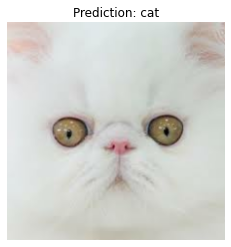

In [34]:
# Test our model on a custom image
pred_and_plot(efficientnetV2_model, "cat.jpg", class_names)

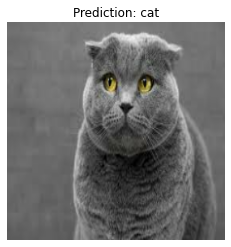

In [35]:
# Test our model on a custom image
pred_and_plot(efficientnetV2_model, "cat2.jpg", class_names)

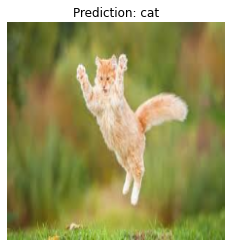

In [36]:
# Test our model on a custom image
pred_and_plot(efficientnetV2_model, "cat3.jpg", class_names)

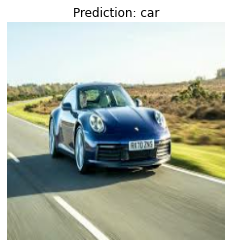

In [37]:
# Test our model on a custom image
pred_and_plot(efficientnetV2_model, "car.jpg", class_names)

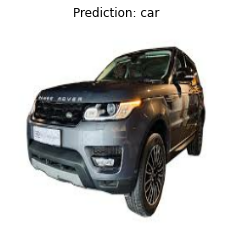

In [38]:
# Test our model on a custom image
pred_and_plot(efficientnetV2_model, "car2.jpg", class_names)

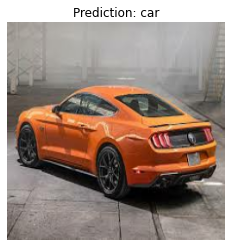

In [39]:
# Test our model on a custom image
pred_and_plot(efficientnetV2_model, "car3.jpg", class_names)